In [52]:
import pandas as pd
import numpy as np
from itertools import combinations

from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (cross_val_score, GridSearchCV, KFold, LeaveOneOut,
                                     ShuffleSplit, StratifiedKFold, train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
import mne
from mne_connectivity.viz import plot_connectivity_circle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


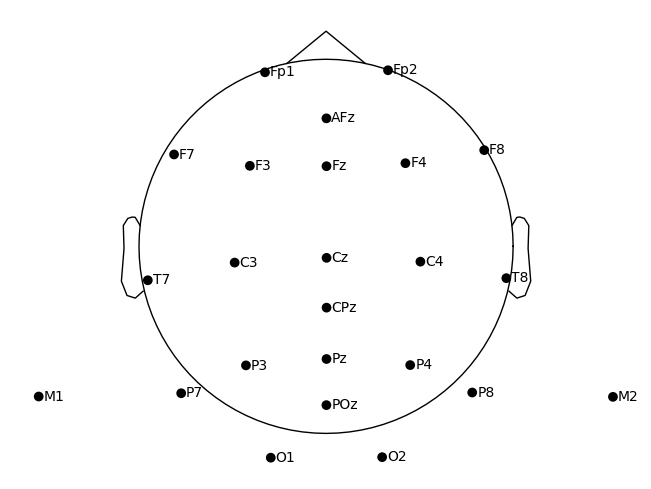

In [53]:
# Define your channels
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
            'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 
            'M2', 'AFz', 'CPz', 'POz']

# Create a standard montage
montage = mne.channels.make_standard_montage('standard_1020')

# Extract positions of the specified channels
selected_pos = {ch: montage.get_positions()['ch_pos'][ch] for ch in channels}

# Create custom montage
custom_montage = mne.channels.make_dig_montage(ch_pos=selected_pos, coord_frame='head')

# Create an info structure with these channels
info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')

# Set the montage to the info object
info.set_montage(custom_montage)

# Plot the montage
custom_montage.plot(kind='topomap', show_names=True)

# Optionally, to see the plot in an interactive way
plt.show()


## Data Wrangling

In [54]:

X_files = ['Data/bandpower_delta.csv', 'Data/bandpower_theta.csv', 'Data/bandpower_alpha.csv', 'Data/bandpower_beta.csv', 'Data/bandpower_gamma.csv', 'Data/coherence_delta.csv', 'Data/coherence_theta.csv', 'Data/coherence_alpha.csv', 'Data/coherence_beta.csv', 'Data/coherence_gamma.csv']
Y_files = 'Data/stress_raw.csv'

In [55]:
#EEG features
X_dfs = [pd.read_csv(file) for file in X_files]

Y_dfs = pd.read_csv(Y_files)
Y_dfs = pd.DataFrame(Y_dfs)

Y_dfs = Y_dfs.rename(columns={'4': 'raw_stress'})

In [56]:
bins = [0, 3, 7, 10]  # Bin edges for low, mid, and high stress
labels = [0, 1, 2]  # Numeric labels for low, mid, and high

Y_dfs['stress_state'] = pd.cut(Y_dfs.iloc[:, 0], bins=bins, labels=labels, include_lowest=True)
Y_dfs['stress_state'] = Y_dfs['stress_state'].astype(int)

In [57]:
num_rows = len(X_dfs[0])
combined_rows = [pd.concat([df.iloc[i] for df in X_dfs], ignore_index=True) for i in range(num_rows)]


X_dfs = pd.concat(combined_rows, axis=1).transpose()

In [58]:
stress_counts = Y_dfs['stress_state'].value_counts()

print(stress_counts)

stress_state
1    546
2    370
0    245
Name: count, dtype: int64


In [60]:
Y_dfs = Y_dfs.drop(range(83, 167), axis=0)
X_dfs = X_dfs.drop(range(83, 167), axis=0)

In [62]:
bp = ['delta_', 'theta_', 'alpha_', ' beta_', 'gamma_']
column_labels_bandpower = ['Fp1',	'Fp2',	'F3',	'F4',	'C3',	'C4',	'P3',	'P4',	'O1',	'O2',	'F7',	'F8',	'T7',	'T8',	'P7',	'P8',	'Fz',	'Cz',	'Pz',	'M1',	'M2',	'AFz',	'CPz',	'POz']
column_labels_bandpower_final = []
for x in range(0,5):
    for name in column_labels_bandpower:
        column_labels_bandpower_final.append(bp[x] + name)

bp = ['delta_', 'theta_', 'alpha_', ' beta_', 'gamma_']
column_labels_coherence = ['Fp1-Fp2','Fp1-F3','Fp1-F4','Fp1-C3','Fp1-C4','Fp1-P3','Fp1-P4','Fp1-O1','Fp1-O2','Fp1-F7','Fp1-F8','Fp1-T7','Fp1-T8','Fp1-P7','Fp1-P8','Fp1-Fz','Fp1-Cz','Fp1-Pz','Fp1-M1','Fp1-M2','Fp1-AFz','Fp1-CPz','Fp1-POz','Fp2-F3','Fp2-F4','Fp2-C3','Fp2-C4','Fp2-P3','Fp2-P4','Fp2-O1','Fp2-O2','Fp2-F7','Fp2-F8','Fp2-T7','Fp2-T8','Fp2-P7','Fp2-P8','Fp2-Fz','Fp2-Cz','Fp2-Pz','Fp2-M1','Fp2-M2','Fp2-AFz','Fp2-CPz','Fp2-POz','F3-F4','F3-C3','F3-C4','F3-P3','F3-P4','F3-O1','F3-O2','F3-F7','F3-F8','F3-T7','F3-T8','F3-P7','F3-P8','F3-Fz','F3-Cz','F3-Pz','F3-M1','F3-M2','F3-AFz','F3-CPz','F3-POz','F4-C3','F4-C4','F4-P3','F4-P4','F4-O1','F4-O2','F4-F7','F4-F8','F4-T7','F4-T8','F4-P7','F4-P8','F4-Fz','F4-Cz','F4-Pz','F4-M1','F4-M2','F4-AFz','F4-CPz','F4-POz','C3-C4','C3-P3','C3-P4','C3-O1','C3-O2','C3-F7','C3-F8','C3-T7','C3-T8','C3-P7','C3-P8','C3-Fz','C3-Cz','C3-Pz','C3-M1','C3-M2','C3-AFz','C3-CPz','C3-POz','C4-P3','C4-P4','C4-O1','C4-O2','C4-F7','C4-F8','C4-T7','C4-T8','C4-P7','C4-P8','C4-Fz','C4-Cz','C4-Pz','C4-M1','C4-M2','C4-AFz','C4-CPz','C4-POz','P3-P4','P3-O1','P3-O2','P3-F7','P3-F8','P3-T7','P3-T8','P3-P7','P3-P8','P3-Fz','P3-Cz','P3-Pz','P3-M1','P3-M2','P3-AFz','P3-CPz','P3-POz','P4-O1','P4-O2','P4-F7','P4-F8','P4-T7','P4-T8','P4-P7','P4-P8','P4-Fz','P4-Cz','P4-Pz','P4-M1','P4-M2','P4-AFz','P4-CPz','P4-POz','O1-O2','O1-F7','O1-F8','O1-T7','O1-T8','O1-P7','O1-P8','O1-Fz','O1-Cz','O1-Pz','O1-M1','O1-M2','O1-AFz','O1-CPz','O1-POz','O2-F7','O2-F8','O2-T7','O2-T8','O2-P7','O2-P8','O2-Fz','O2-Cz','O2-Pz','O2-M1','O2-M2','O2-AFz','O2-CPz','O2-POz','F7-F8','F7-T7','F7-T8','F7-P7','F7-P8','F7-Fz','F7-Cz','F7-Pz','F7-M1','F7-M2','F7-AFz','F7-CPz','F7-POz','F8-T7','F8-T8','F8-P7','F8-P8','F8-Fz','F8-Cz','F8-Pz','F8-M1','F8-M2','F8-AFz','F8-CPz','F8-POz','T7-T8','T7-P7','T7-P8','T7-Fz','T7-Cz','T7-Pz','T7-M1','T7-M2','T7-AFz','T7-CPz','T7-POz','T8-P7','T8-P8','T8-Fz','T8-Cz','T8-Pz','T8-M1','T8-M2','T8-AFz','T8-CPz','T8-POz','P7-P8','P7-Fz','P7-Cz','P7-Pz','P7-M1','P7-M2','P7-AFz','P7-CPz','P7-POz','P8-Fz','P8-Cz','P8-Pz','P8-M1','P8-M2','P8-AFz','P8-CPz','P8-POz','Fz-Cz','Fz-Pz','Fz-M1','Fz-M2','Fz-AFz','Fz-CPz','Fz-POz','Cz-Pz','Cz-M1','Cz-M2','Cz-AFz','Cz-CPz','Cz-POz','Pz-M1','Pz-M2','Pz-AFz','Pz-CPz','Pz-POz','M1-M2','M1-AFz','M1-CPz','M1-POz','M2-AFz','M2-CPz','M2-POz','AFz-CPz','AFz-POz','CPz-POz']
column_labels_coherence_final = []
for x in range(0,5):
    for name in column_labels_coherence:
        column_labels_coherence_final.append(bp[x] + name)

column_labels = column_labels_bandpower_final+column_labels_coherence_final
X_dfs.columns = column_labels

ranges = [
    (0, 82),
    (83, 235),
    (236, 383),
    (384, 500),
    (501, 638),
    (639, 787),
    (788, 919),
    (920, 1076)
]

subjects = []

for i, (start, end) in enumerate(ranges, start=1):
    subjects.extend([f'Subject{i}'] * (end - start + 1))



X_dfs.index = subjects
Y_dfs.index = subjects

X_dfs_bandpower = X_dfs.iloc[:, :120]
X_dfs_coherence = X_dfs.iloc[:, 120:]

In [65]:
X_dfs

,delta_Fp1,delta_Fp2,delta_F3,delta_F4,delta_C3,delta_C4,delta_P3,delta_P4,delta_O1,delta_O2,...,gamma_M1-M2,gamma_M1-AFz,gamma_M1-CPz,gamma_M1-POz,gamma_M2-AFz,gamma_M2-CPz,gamma_M2-POz,gamma_AFz-CPz,gamma_AFz-POz,gamma_CPz-POz
Subject1,0.394307,1.599747,2.726823,-2.992742,-2.372566,1.148198,2.393122,0.155264,5.803184,4.261109,...,0.092195,0.084965,0.154651,0.128792,0.188102,0.160442,0.159875,0.482598,0.663322,0.894273
Subject1,-0.149713,5.966694,3.829170,1.239717,-2.367881,-0.490503,0.622708,0.535046,4.884100,4.777934,...,0.117915,0.089701,0.126930,0.109031,0.117394,0.187809,0.150613,0.364265,0.456044,0.884439
Subject1,-3.183797,4.650560,-0.602012,-0.150686,-0.804464,-0.606826,-2.568157,-2.674325,4.049312,2.593247,...,0.099517,0.129662,0.315088,0.245590,0.149354,0.070111,0.098800,0.424306,0.597513,0.901940
Subject1,-2.110095,9.834378,0.788589,0.014000,0.151777,3.278379,-0.690953,-2.195723,5.784860,5.890014,...,0.066678,0.097632,0.236255,0.191423,0.166667,0.110135,0.111779,0.388794,0.583179,0.871656
Subject1,-3.829407,5.750818,1.270700,2.094251,-2.651974,-0.266506,0.423327,-2.014899,7.122095,4.692419,...,0.102767,0.118291,0.209949,0.158469,0.133713,0.125637,0.089462,0.445359,0.592426,0.912373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject8,-4.781852,-3.407849,0.133704,-1.433123,-5.741494,-6.162795,-4.777654,-4.465562,0.620000,-0.614368,...,0.144903,0.354411,0.195450,0.218651,0.197836,0.099939,0.149136,0.196894,0.579481,0.152261
Subject8,-4.427387,-4.001543,1.630305,1.622165,-0.689762,-5.283847,-0.437625,-2.269518,-0.708222,-0.696294,...,0.117010,0.283885,0.172069,0.287374,0.451898,0.263065,0.397970,0.297038,0.635434,0.534678
Subject8,-2.527998,-3.853688,-1.681693,-1.859086,-7.623779,-5.638700,-3.468030,-0.279179,-1.399777,-0.285489,...,0.154552,0.183583,0.097458,0.220496,0.429276,0.139780,0.274604,0.179926,0.461987,0.419484
Subject8,-3.423811,-2.380746,0.490020,-0.515831,-6.459564,-5.191147,-1.723863,-2.384309,-0.699063,-0.756964,...,0.216614,0.284334,0.167149,0.235419,0.258454,0.200145,0.163477,0.222176,0.529587,0.170705


In [66]:
Y_dfs

,raw_stress,stress_state
Subject1,3.1188,1
Subject1,3.3736,1
Subject1,3.7090,1
Subject1,3.7894,1
Subject1,5.6322,1
...,...,...
Subject8,9.9720,2
Subject8,6.8110,1
Subject8,7.6646,2
Subject8,8.0000,2


## Data Vis

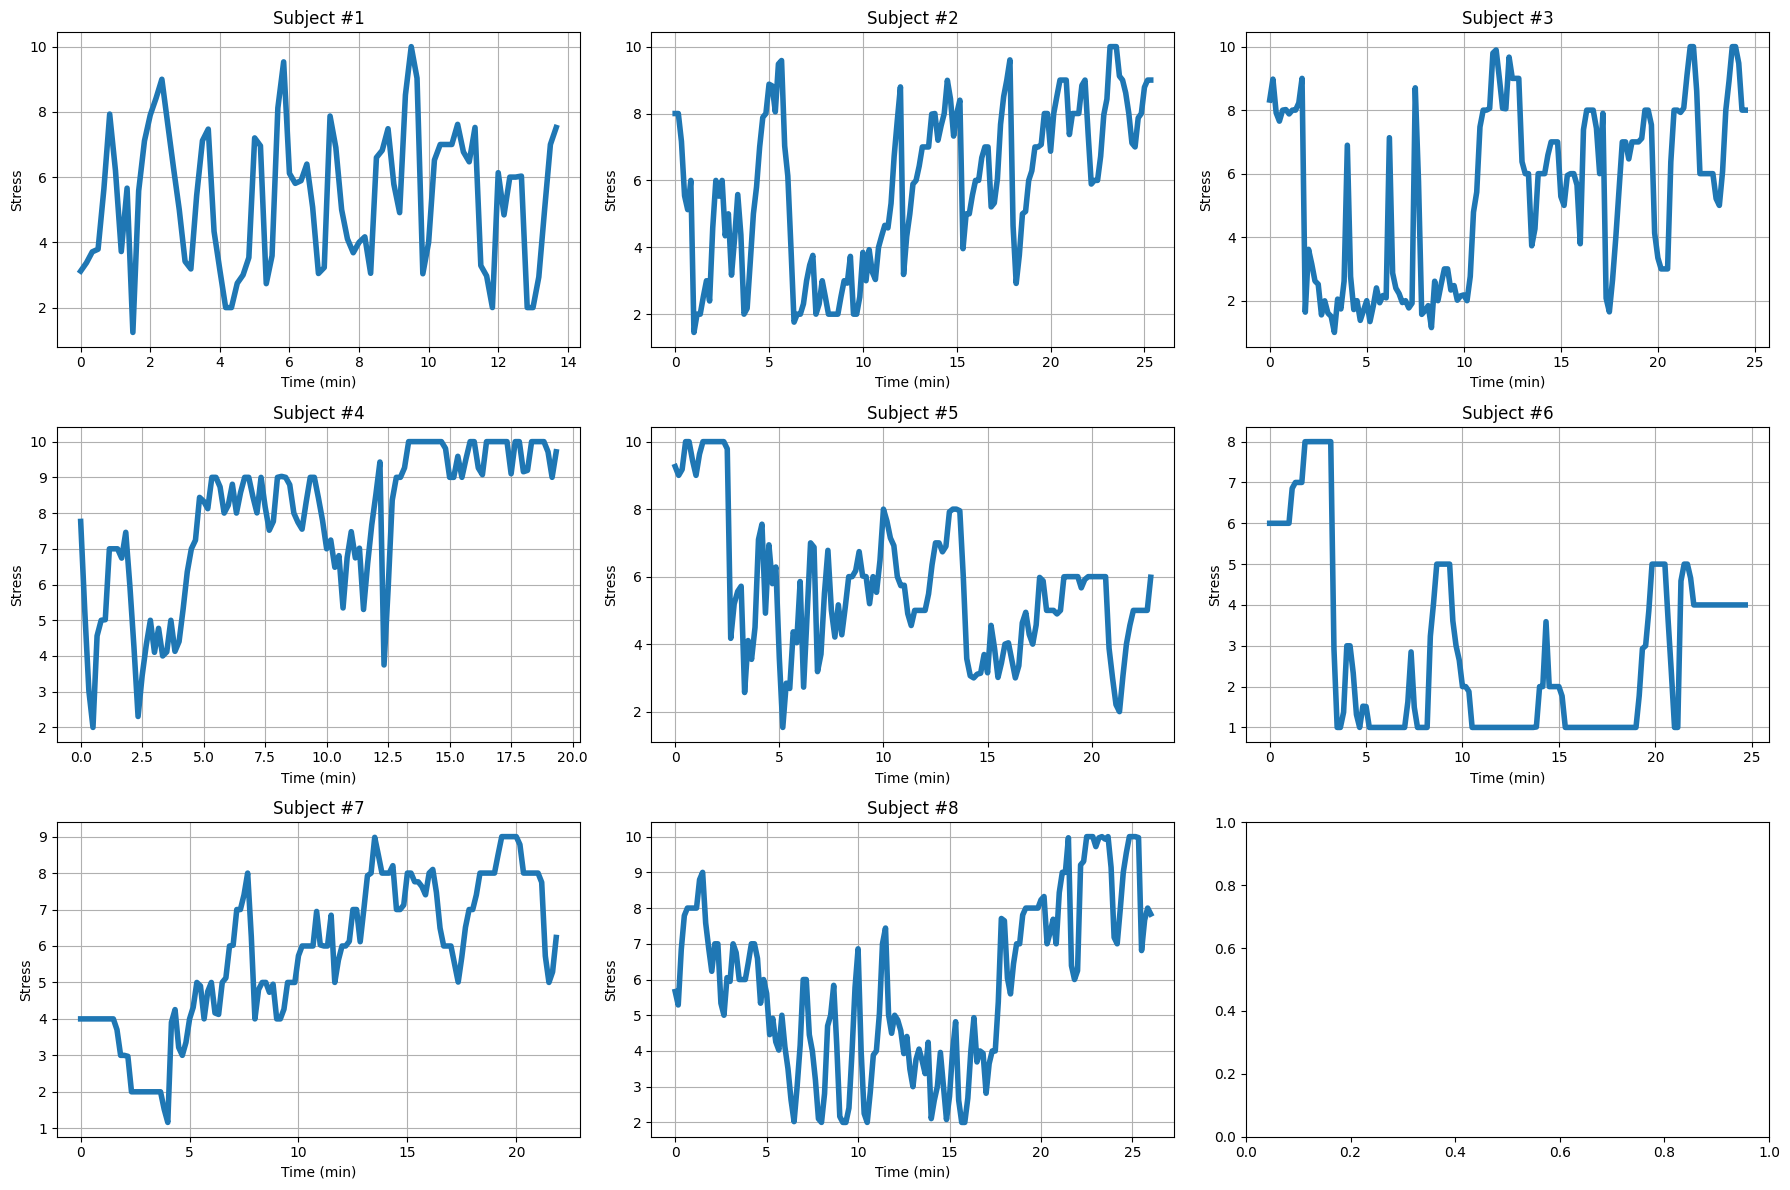

In [63]:
nrows, ncols = 3, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
axes = axes.flatten()  

for i in range(1, 9):
    subject = f'Subject{i}'
    values = Y_dfs["raw_stress"].loc[subject].values.flatten() 

    num_points = len(values)

    minutes = np.arange(0, num_points * 10, 10) / 60  

    ax = axes[i-1]
    ax.plot(minutes, values, linestyle='-', linewidth=4)  
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Stress')
    ax.set_title(f'Subject #{i}')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [117]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dfs)

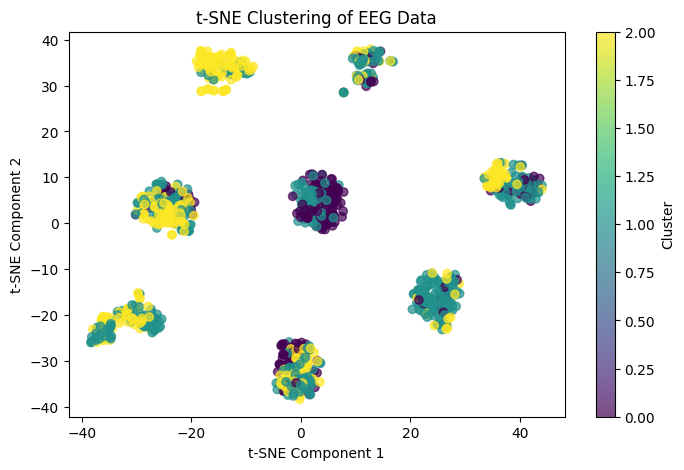

In [118]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_dfs["stress_state"], cmap='viridis', alpha=0.7)
plt.title('t-SNE Clustering of EEG Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

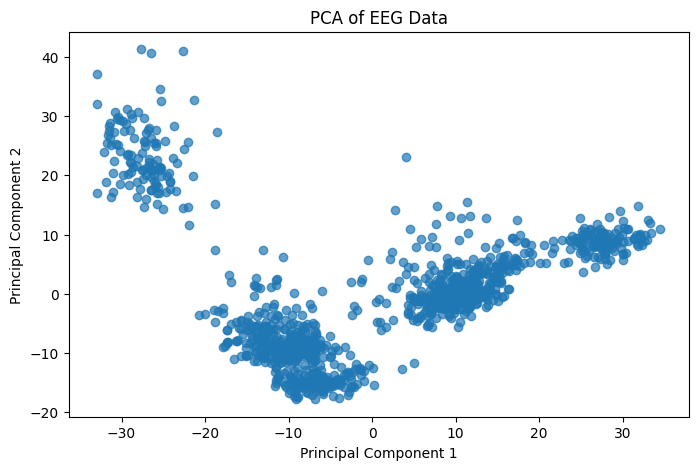

In [119]:
pca = PCA(n_components=2)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Plotting PCA results
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('PCA of EEG Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

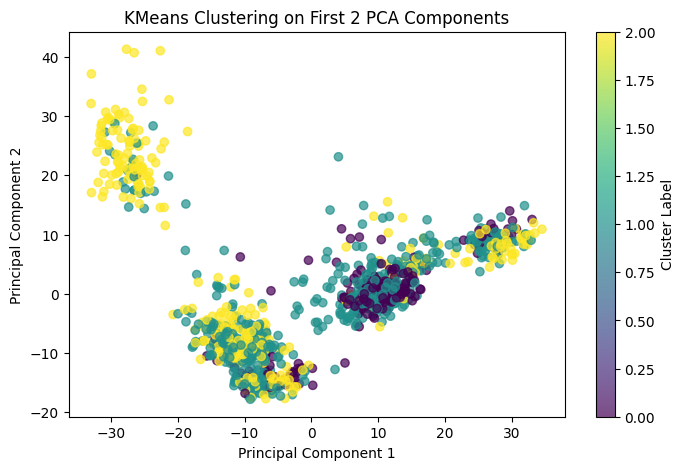

Cluster labels of First 2 PCA Components


In [120]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Assuming X_scaled is your standardized data

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_dfs["stress_state"], cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering on First 2 PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Printing the cluster labels
print(f'Cluster labels of First 2 PCA Components')


steps:

run clasification using non temporal steps


interduce LTSMS to caputure inter spoch temporal patterns

